# SERIAL CODE USING GPU

## DEPENDENCIES

In [1]:
import os
import time
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from sklearn.metrics import classification_report, f1_score

# Suppress all UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Environment Setup - GPU Check and Dataset Configuration

In [2]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths to your dataset
# main_dir = "/home/gurram.ri/Project/CASIA"
main_dir = "/home/sikhakolli.v/Real_VS_AI/CASIA/Au"

# Define batch size and image dimensions
batch_size = 32
img_height = 224
img_width = 224

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Data Preparation and Data Loaders

In [3]:
# Define full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=main_dir, transform=transform)

# Get class names
class_names = full_dataset.classes

# Define a normalization layer to rescale pixel values to [0, 1]
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Split the dataset into training and validation sets
train_size = int(0.9 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Apply the normalization layer to both training and validation datasets
train_dataset.transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    normalization_layer
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    normalization_layer
])

# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Model Evaluation Functions

In [4]:
# Define the function to calculate accuracy and F1 score
def score_model_categorical(model, valid_loader):
    """
    Calculates accuracy and F1 score for a categorical classification model.

    Parameters:
        model (torch.nn.Module): Trained PyTorch model.
        valid_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.

    Prints:
        - Number of errors, accuracy, and F1 score.
        - Classification report (precision, recall, F1-score, support).

    Assumes model has been trained for categorical classification.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    errors = 0
    pred_indices = []
    true_indices = []
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            pred_indices.extend(predicted.cpu().numpy())
            true_indices.extend(labels.cpu().numpy())
            errors += (predicted != labels).sum().item()

    accuracy = (len(pred_indices) - errors) * 100 / len(pred_indices)
    f1score = f1_score(true_indices, pred_indices, average='weighted') * 100
    
    print(f'There were {errors} errors in {len(pred_indices)} tests for an accuracy of {accuracy:.2f} and an F1 score of {f1score:.2f}')
    print(classification_report(true_indices, pred_indices))

In [5]:
def plot_training_history(history, accuracy='accuracy'):
    """
    Plot training and validation loss/accuracy over epochs.

    Parameters:
        history (dict): A dictionary containing training and validation metrics.
            - Keys: 'accuracy', 'loss', 'val_accuracy', 'val_loss'.
            - Values: Lists containing corresponding metric values for each epoch.
        accuracy (str): The name of the accuracy metric to display (default is 'accuracy').

    Prints:
        - Two subplots:
            1. Training and validation loss over epochs.
            2. Training and validation accuracy over epochs.
        - Marks the epoch with the lowest validation loss and highest validation accuracy.

    """
    train_acc = history['accuracy']
    train_loss = history['loss']
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    index_acc = np.argmax(val_acc)
    val_highest = val_acc[index_acc]

    epochs = range(1, len(train_acc) + 1)

    loss_label = f'Best epoch = {index_loss + 1}'
    acc_label = f'Best epoch = {index_acc + 1}'

    # Training history
    plt.figure(figsize=(15, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## EfficientNetB3 Model Definition with Custom Classifier

In [6]:
# Define the EfficientNetB3-based model with custom classifier
class EfficientNetB3(nn.Module):
    """
    EfficientNetB3-based model with custom classifier.

    Args:
        num_classes (int): Number of output classes.

    Attributes:
        base_model (torch.nn.Module): EfficientNetB3 backbone model.
        classifier (torch.nn.Linear): Custom classifier layer.

    Methods:
        forward(x): Forward pass method.

    """
    def __init__(self, num_classes):
        super(EfficientNetB3, self).__init__()
        self.base_model = models.efficientnet_b3(pretrained=True)
        self.base_model.classifier = nn.Identity()  # Remove original classifier
        # Calculate the number of input features dynamically
        num_features = self.base_model(torch.zeros(1, 3, 224, 224)).shape[1]
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

# Define the model
model = EfficientNetB3(num_classes=len(full_dataset.classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Training Loop with Validation and Evaluation

Number of GPUs: 1
Total Samples: 12614
Total Training Samples: 11352, Total Validation Samples: 1262

Epoch [1/20], Time: 99.97 seconds- loss: 0.5097 - sparse_categorical_accuracy: 0.7441
Epoch [2/20], Time: 99.00 seconds- loss: 0.3883 - sparse_categorical_accuracy: 0.8192
Epoch [3/20], Time: 100.83 seconds loss: 0.3399 - sparse_categorical_accuracy: 0.8383
Epoch [4/20], Time: 100.05 seconds loss: 0.3064 - sparse_categorical_accuracy: 0.8553
Epoch [5/20], Time: 101.86 seconds loss: 0.2883 - sparse_categorical_accuracy: 0.8630
Epoch [6/20], Time: 99.94 seconds- loss: 0.2635 - sparse_categorical_accuracy: 0.8774
Epoch [7/20], Time: 99.72 seconds- loss: 0.2483 - sparse_categorical_accuracy: 0.8795
Epoch [8/20], Time: 97.98 seconds- loss: 0.2353 - sparse_categorical_accuracy: 0.8849
Epoch [9/20], Time: 98.63 seconds- loss: 0.2245 - sparse_categorical_accuracy: 0.8930
Epoch [10/20], Time: 97.84 seconds loss: 0.2129 - sparse_categorical_accuracy: 0.8986
Epoch [11/20], Time: 99.04 seconds los

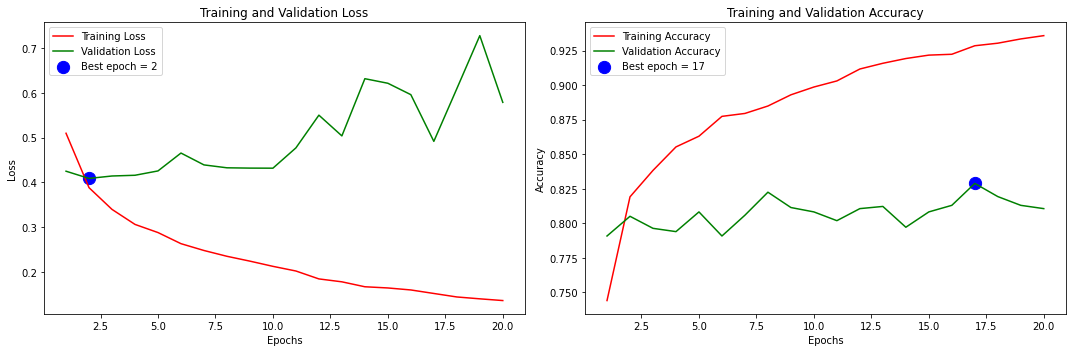

In [7]:
# Training loop
epochs = 20
train_losses = []  # For tracking training loss
train_accuracies = []
valid_losses = []  # For tracking validation loss
valid_accuracies = []

# Start time of training
start_time = time.time()

print(f'Number of GPUs: {torch.cuda.device_count()}')

print(f'Total Samples: {len(train_loader.dataset) + len(valid_loader.dataset)}')
print(f'Total Training Samples: {len(train_loader.dataset)}, Total Validation Samples: {len(valid_loader.dataset)}\n')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start_time = time.time()  # Start time of epoch

    for step, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print training progress
        if step % len(train_loader) == 0:
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = correct / total
            train_losses.append(epoch_loss)  # Save training loss for this epoch
            train_accuracies.append(epoch_acc)
            print(f"{step}/{len(train_loader)} - {time.time() - epoch_start_time:.0f}s - {time.time() - epoch_start_time / step:.0f}s/step - loss: {epoch_loss:.4f} - sparse_categorical_accuracy: {epoch_acc:.4f}", end='\r')

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_loader)
    valid_losses.append(val_loss)  # Save validation loss for this epoch
    valid_accuracies.append(val_accuracy)

    # End time of epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # Print epoch summary including time taken
    print(f'Epoch [{epoch + 1}/{epochs}], Time: {epoch_duration:.2f} seconds')
    
    # Early stopping based on validation accuracy
    # if val_accuracy > best_val_acc:
    #     best_val_acc = val_accuracy
    #     counter = 0
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print("Early stopping.")
    #         break

# End time of training
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f}s")

# Print predictions, errors, accuracy, and F1 score
score_model_categorical(model, valid_loader)

# Plot the training history
history = {'loss': train_losses, 'accuracy': train_accuracies, 'val_loss': valid_losses, 'val_accuracy': valid_accuracies}
plot_training_history(history)